# World of Warcraft: Avatar Data Analysis
    Author: Liao Wen

Project Contents:
1. EDA based on real game-world experience
2. Simple Recommender for Future Players
3. K-Means Clustering
4. Graph Centrality

In [735]:
import pandas as pd
import numpy as np
from sklearn import datasets
from sklearn.cluster import KMeans
#Kmeans requires scaled input
from sklearn.preprocessing import StandardScaler

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# EDA based on real game-world experience

In [736]:
#Import World of warcraft Dataset
wow = pd.read_csv("wow.csv")
wow.index = wow.index + 1

In [737]:
#Display number of rows and columns in the imported dataste
wow.shape

(1048575, 7)

In [738]:
wow.isnull().T.any().T.sum()

0

In [739]:
#Number of missing values in each variable
wow.isnull().sum()

Character    0
Level        0
Race         0
Class        0
Zone         0
Guild        0
Timestamp    0
dtype: int64

No missing value detected, but we have to recheck.
Because in MMORPG (Massively multiplayer Online Role-Playing Games), 
it is possible that players choose to not join in any guild, e.g. I have 11 characters, only one of them is actually in a guild.
Therefore, the value of guild could logically be zero or higher but could not be negative.

In [740]:
#Display the first few rows so we know the general structure of this dataset
wow.head(5)

,Character,Level,Race,Class,Zone,Guild,Timestamp
1,59425,1,Orc,Rogue,Orgrimmar,165,1/1/2008 0:02
2,65494,9,Orc,Hunter,Durotar,-1,1/1/2008 0:02
3,65325,14,Orc,Warrior,Ghostlands,-1,1/1/2008 0:02
4,65490,18,Orc,Hunter,Ghostlands,-1,1/1/2008 0:02
5,2288,60,Orc,Hunter,Hellfire Peninsula,-1,1/1/2008 0:02


The column index indicates the observasions of records through every timestamp
The guild column indicates how many guilds these characters come from.
Here we have found a bunch of -1s in the guild column, we might be able to detect more negative values
However, if you chage the displaying rows in my code, you would find the only non-positive Guild is -1, 
which means the original data collection marked the guildless records as -1, which were supposed to be 0.
So we need to make the correction.

We can see that there are several observations were at 0:02 on January, 2008,
Which means there is big time interval amongst the observations of the records.
That's why we are going to drop them.

In [741]:
#Drop meaningless variables such as the Timestamp, which represents the records that were collected by milliseconds.
wow = wow.drop(['Timestamp'], axis=1)
wow.describe()

,Character,Level,Guild
count,1.048575e+06,1.048575e+06,1.048575e+06
mean,3.722180e+04,6.056243e+01,1.218761e+02
std,2.172658e+04,1.784720e+01,9.460111e+01
min,7.000000e+00,1.000000e+00,-1.000000e+00
25%,2.209800e+04,6.100000e+01,3.500000e+01
50%,3.610600e+04,7.000000e+01,1.030000e+02
75%,5.950700e+04,7.000000e+01,2.040000e+02
max,6.704300e+04,7.000000e+01,3.160000e+02


In [742]:
#Get categorical variables
def describe_categorical(wow):
    from IPython.display import display, HTML
    display(HTML(wow[wow.columns[wow.dtypes == "object"]].describe().to_html()))
describe_categorical(wow)

,Race,Class,Zone
count,1048575,1048575,1048575
unique,5,9,111
top,Blood Elf,Hunter,Shattrath City
freq,368392,155891,101972


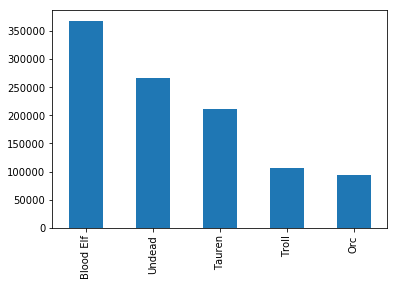

In [743]:
wow.Race.value_counts().plot(kind='bar')

Blood Elf appeared to be the most popular choice in 2007, 
but it is werid that Orc became the last option rather than Tauren.

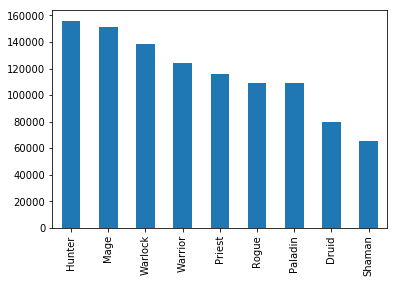

In [744]:
wow.Class.value_counts().plot(kind='bar')

Hunter, Mage and Warlock were the most widely chosen classes during that time.

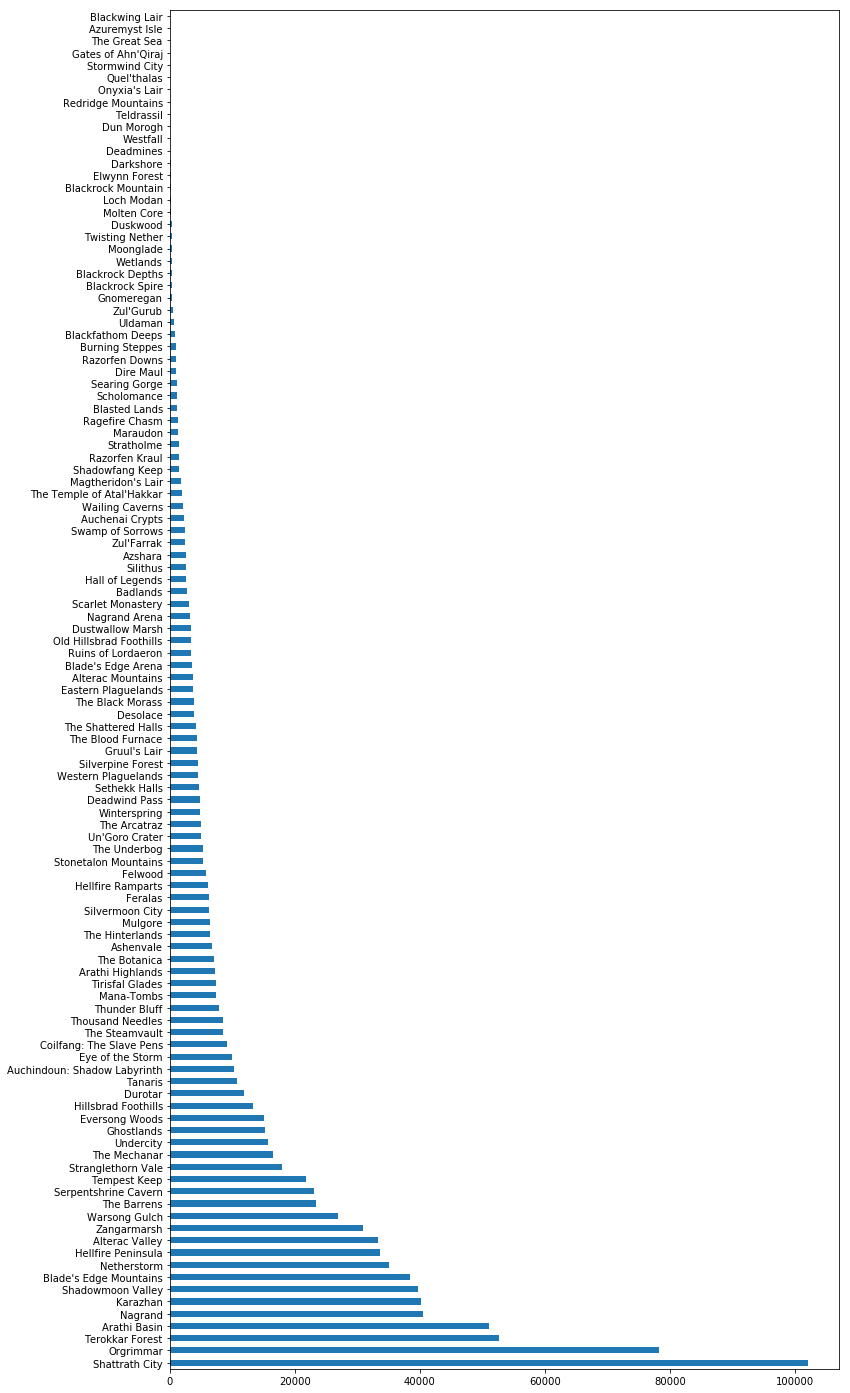

In [745]:
wow.Zone.value_counts().plot(kind='barh', figsize=(12,25))

The dataset is collected during January, 2008.
In 2007, you go to Shattrath City as much as you go to your office (For trading, quests, learning skills, etc.)
Orgrimmar is Horde's capital city, Stormwind is Alliance' capital city.
(Horde and Alliance ≈ Decepticons and Autobots in the Movie Transformers)

In [746]:
#Convert categorical data into dummy/numeric variables
categorical_variables = ['Race', 'Class', 'Zone']
for wowvariable in categorical_variables:
    # Fill missing data with the word "Missing"
    wow[wowvariable].fillna("Missing", inplace=True)
    # Create array of dummies
    dummies = pd.get_dummies(wow[wowvariable], prefix=None)
    # Update wow to include dummies and drop the main variable
    wow = pd.concat([wow, dummies], axis=1)
    wow.drop([wowvariable], axis=1, inplace=True)

In [747]:
#Show all the columns in the converted wow dataset
def printall(wow, max_rows=10):
    from IPython.display import display, HTML
    display(HTML(wow.to_html(max_rows=max_rows)))
    
printall(wow.head())

,Character,Level,Guild,Blood Elf,Orc,Tauren,Troll,Undead,Druid,Hunter,Mage,Paladin,Priest,Rogue,Shaman,Warlock,Warrior,Alterac Mountains,Alterac Valley,Arathi Basin,Arathi Highlands,Ashenvale,Auchenai Crypts,Auchindoun: Shadow Labyrinth,Azshara,Azuremyst Isle,Badlands,Blackfathom Deeps,Blackrock Depths,Blackrock Mountain,Blackrock Spire,Blackwing Lair,Blade's Edge Arena,Blade's Edge Mountains,Blasted Lands,Burning Steppes,Coilfang: The Slave Pens,Darkshore,Deadmines,Deadwind Pass,Desolace,Dire Maul,Dun Morogh,Durotar,Duskwood,Dustwallow Marsh,Eastern Plaguelands,Elwynn Forest,Eversong Woods,Eye of the Storm,Felwood,Feralas,Gates of Ahn'Qiraj,Ghostlands,Gnomeregan,Gruul's Lair,Hall of Legends,Hellfire Peninsula,Hellfire Ramparts,Hillsbrad Foothills,Karazhan,Loch Modan,Magtheridon's Lair,Mana-Tombs,Maraudon,Molten Core,Moonglade,Mulgore,Nagrand,Nagrand Arena,Netherstorm,Old Hillsbrad Foothills,Onyxia's Lair,Orgrimmar,Quel'thalas,Ragefire Chasm,Razorfen Downs,Razorfen Kraul,Redridge Mountains,Ruins of Lordaeron,Scarlet Monastery,Scholomance,Searing Gorge,Serpentshrine Cavern,Sethekk Halls,Shadowfang Keep,Shadowmoon Valley,Shattrath City,Silithus,Silvermoon City,Silverpine Forest,Stonetalon Mountains,Stormwind City,Stranglethorn Vale,Stratholme,Swamp of Sorrows,Tanaris,Teldrassil,Tempest Keep,Terokkar Forest,The Arcatraz,The Barrens,The Black Morass,The Blood Furnace,The Botanica,The Great Sea,The Hinterlands,The Mechanar,The Shattered Halls,The Steamvault,The Temple of Atal'Hakkar,The Underbog,Thousand Needles,Thunder Bluff,Tirisfal Glades,Twisting Nether,Uldaman,Un'Goro Crater,Undercity,Wailing Caverns,Warsong Gulch,Western Plaguelands,Westfall,Wetlands,Winterspring,Zangarmarsh,Zul'Farrak,Zul'Gurub
1,59425,1,165,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,65494,9,-1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,65325,14,-1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,65490,18,-1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2288,60,-1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


We can see that all three categorical values are all separately displayed in numeric values 
instead of showing the collective number of occurrence.
But we have to remove the large amount of 0s because we only need the actual physical occurrences of those characters.

In [748]:
#Let's use mask to drop the all zeros rows
#wow.loc[~(wow['Guild'] = 0)]
mask = np.all(wow == 0, axis=1)
wow = wow[~mask]
wow.head()

,Character,Level,Guild,Blood Elf,Orc,Tauren,Troll,Undead,Druid,Hunter,...,Undercity,Wailing Caverns,Warsong Gulch,Western Plaguelands,Westfall,Wetlands,Winterspring,Zangarmarsh,Zul'Farrak,Zul'Gurub
1,59425,1,165,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,65494,9,-1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,65325,14,-1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,65490,18,-1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,2288,60,-1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [749]:
wow=wow.replace([-1], [0])
wow.replace([-1], [0])
wow.head()

,Character,Level,Guild,Blood Elf,Orc,Tauren,Troll,Undead,Druid,Hunter,...,Undercity,Wailing Caverns,Warsong Gulch,Western Plaguelands,Westfall,Wetlands,Winterspring,Zangarmarsh,Zul'Farrak,Zul'Gurub
1,59425,1,165,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,65494,9,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,65325,14,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,65490,18,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,2288,60,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


Back to the guild value. Since there are more than 1 million records in our dataset, 
we would choose to replace all those guild status that are -1 with 0.
The reason we place this step after the previous step is to avoid misdelete the guildless records.
There could be many guildless characters, but this is online game, one player could own multiple toons.
I have 11 and most are super low level, because I dont have much time to manage them, so they are guildless as well.

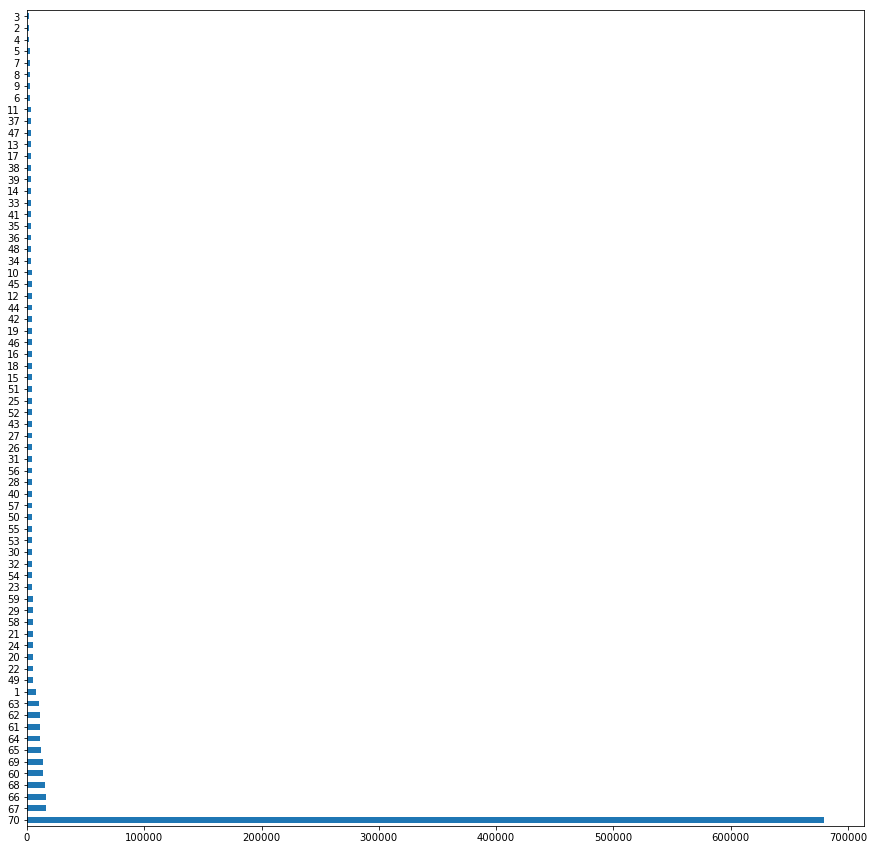

In [750]:
wow.Level.value_counts().plot(kind='barh', figsize=(15,15))

The horizontal bar plot indicates that the activity of high level players is much higher.
This is quite understandable, because the access of large amount of high quality contents such as 
raid dungeons and some challenging quests has high requirements on player's' level and gear.
Simply speaking, full level players and the rest are playing different games.

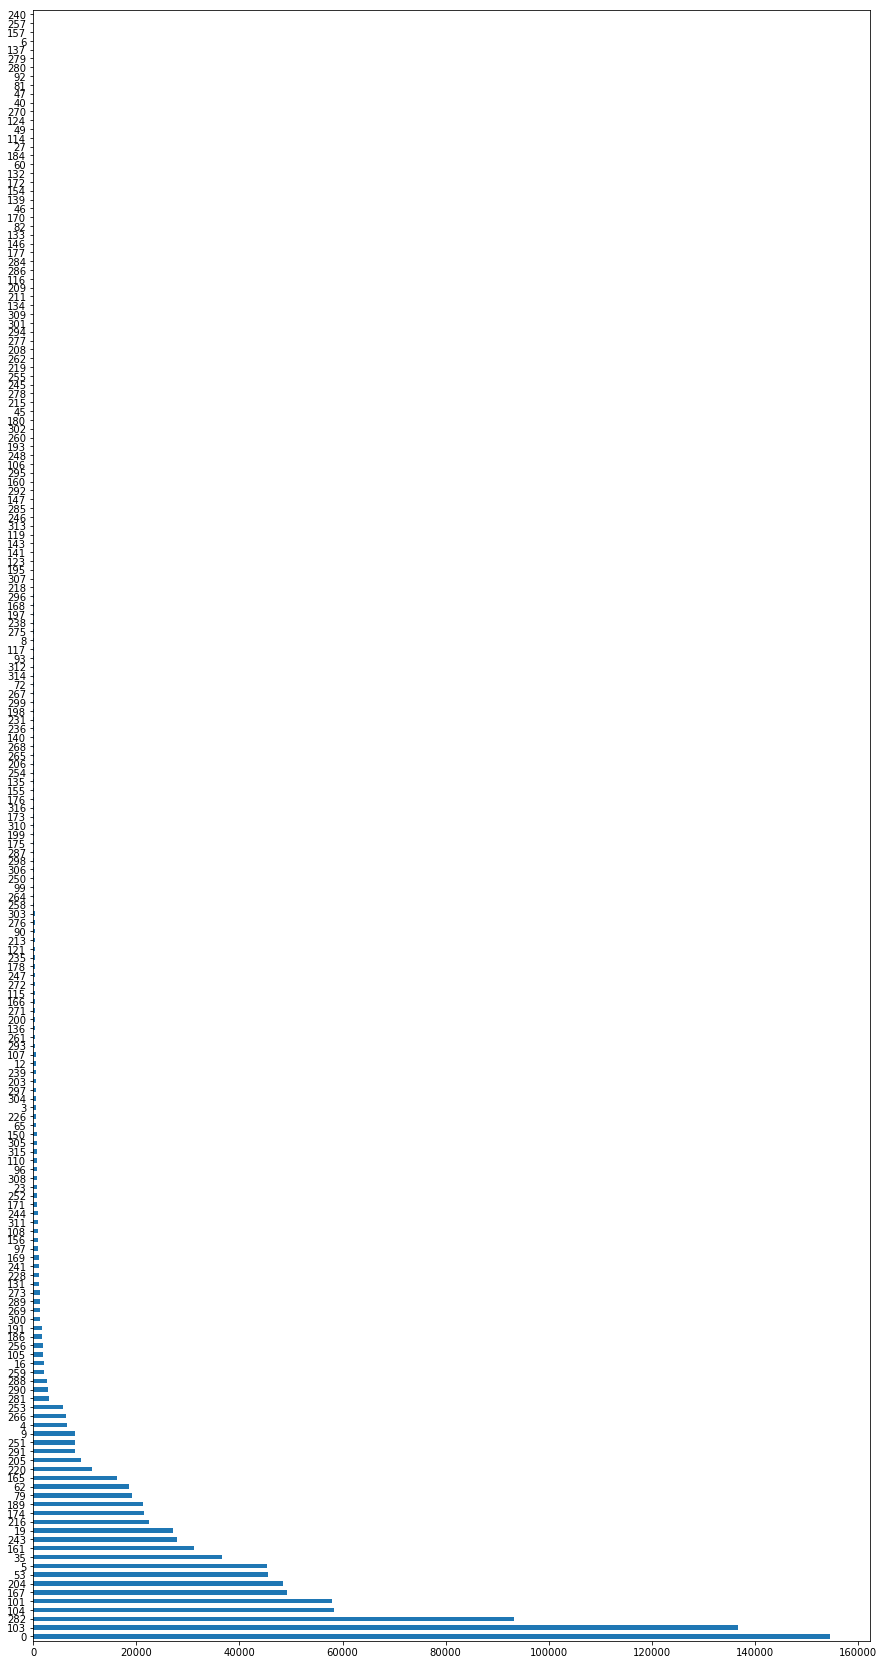

In [751]:
#Or we want to know how social the players seem to be.
wow.Guild.value_counts().plot(kind='barh', figsize=(15,30))

Notice that one player could own multiple accounts, so the large amount of guildless records 
doesn't represent all characters.

# Simple Recommender for Future Players

In [752]:
#Based on the learning above, we are building a recommender for future players
def pearson(s1, s2):
    """Take two pd.Series objects and return a pearson correlation."""
    s1_c = s1 - s1.mean()
    s2_c = s2 - s2.mean()
    return np.sum(s1_c * s2_c) / np.sqrt(np.sum(s1_c ** 2) * np.sum(s2_c ** 2))

Building a recommender for future players

In [753]:
def get_recs(movie_name, M, num):

    import numpy as np
    reviews = []
    for title in M.columns:
        if title == movie_name:
            continue
        cor = pearson(M[movie_name], M[title])
        if np.isnan(cor):
            continue
        else:
            reviews.append((title, cor))
    
    reviews.sort(key=lambda tup: tup[1], reverse=True)
    return reviews[:num]

If you are totally a new player who has no idea how these game races and classes perform like,
we would like to randomly pick a class to check which classes are most compatible to this one.
We found Tauren and Orc as your best races for warrior, this is exactly what the real game world tells.
The racial traits of Tauren (War Stomp, Brawn) and Orc (Blood Fury, Hardiness) are perfectly designed for melee classes.

In [754]:
#Display what are the most related classes, zones and the best races that fit the target class
recs = get_recs('Warrior', wow, 16)
recs[:5]

[('Tauren', 0.29017970374342078),
 ('Orc', 0.18005741988905866),
 ('Level', 0.060255663650131776),
 ('Mulgore', 0.031153223854511837),
 ('Arathi Basin', 0.023151511984925637)]

The most popular Race for Warrior is Tauren

In [755]:
#How about mage? If you prefer casting cool magic spells as a ranged class?
recs = get_recs('Mage', wow, 16)
recs[:5]

[('Undead', 0.21459095318882551),
 ('Level', 0.049975225224638847),
 ('Blood Elf', 0.046789425913050166),
 ('Guild', 0.034114878408387457),
 ('Netherstorm', 0.028558212997081545)]

The most popular Race for Mage is Undead

Reminder:
The racial traits changes in every different expansion of this game,
But Undead Mage was a bug in 2007 known by the will of the Forsaken,
which removes any Charm, Fear, or Sleep effect and provides immunity 
to them for 5 seconds (Used to be > 20 seconds)

In [756]:
#Well, I enjoy being a noob regardless of damage dealing, combat skills and #@$%,
#I only go for the look, like, Blood Elf, class is always my second concern.
recs = get_recs('Blood Elf', wow, 16)
recs[:5]

[('Character', 0.49703591819980875),
 ('Paladin', 0.46218226894921061),
 ('Eversong Woods', 0.15607072647371925),
 ('Ghostlands', 0.12850853889489211),
 ('Silvermoon City', 0.090937522151570568)]

Some Blood Elf paladins only require two types button to play: action buttons and the key binding of dress-changing.

# Kmeans Clustering

Our next step is using Kmeans clustering to help our machine learning.
The major obstacle that we are facing is the large size of our data and the poor hardware environment.
So we need to downsize our data by having the most useful values left.
We have considered dropping some rows that contain zeros but our data are largely scattered throughout 
more than one million observations containing no empty row or column.
Finally, we decide to select records that has the highest activeness based on previous 
horizontal bar plot in the scale of the player level, guild status and instant records collection.

In [757]:
#First, we select only level 70 players, then received 679569 records;
wow70=wow.loc[(wow['Level'] == 70)]
#Second, we sort by guild status to let the most active players stay on top
wow70guild=wow70.sort_values(by='Guild', ascending=0)
#Finally, we select only the top 100 records as our new data sample
wow70guild.iloc[0:100]
#Drop colum Level since it contains the same value
wowsmall = wow70guild.iloc[0:100].drop(['Level'], axis=1)
#Rename index
wowsmall.index.name='Observers'
wowsmall

,Character,Guild,Blood Elf,Orc,Tauren,Troll,Undead,Druid,Hunter,Mage,...,Undercity,Wailing Caverns,Warsong Gulch,Western Plaguelands,Westfall,Wetlands,Winterspring,Zangarmarsh,Zul'Farrak,Zul'Gurub
Observers,,,,,,,,,,,,,,,,,,,,,
972793,65918,316,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
973414,65918,316,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
950596,65918,316,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
951117,65918,316,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
974003,65918,316,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
951369,65918,316,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
970824,65918,316,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
951647,65918,316,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
972151,65918,316,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [758]:
#feature scaling
scaler = StandardScaler()
wowsmall_scaled = scaler.fit_transform(wowsmall)

In [759]:
#wowsmall is transformed into scales based on the Standard Deviation of 
#each column in the table above
wowsmall_scaled

array([[ 1.89257614,  2.4784788 , -0.4843221 , ..., -0.14285714,
         0.        ,  0.        ],
       [ 1.89257614,  2.4784788 , -0.4843221 , ..., -0.14285714,
         0.        ,  0.        ],
       [ 1.89257614,  2.4784788 , -0.4843221 , ..., -0.14285714,
         0.        ,  0.        ],
       ..., 
       [ 0.3753479 , -0.40347329, -0.4843221 , ..., -0.14285714,
         0.        ,  0.        ],
       [ 0.0756259 , -0.40347329, -0.4843221 , ...,  7.        ,
         0.        ,  0.        ],
       [-1.60582485, -0.40347329, -0.4843221 , ..., -0.14285714,
         0.        ,  0.        ]])

In [760]:
def find_k (wowsmall, k_range, sample_percent=1):
    """
    k_range: a list of possible k values
    X, the data we're clustering on
    """
    from sklearn.cluster import KMeans
    import matplotlib.pyplot as plt
    import numpy as np
    from scipy.spatial.distance import cdist
    from sklearn.metrics import pairwise_distances

    N = wowsmall.shape[0]
    sampleSize = wowsmall.shape[0] * sample_percent

    if sampleSize > 0:
        index = np.arange(np.shape(wowsmall)[0])
        np.random.shuffle(index)
        wowsmall =  wowsmall[index, :]


    mean_distortions=[]
    for k in k_range:
        #cluster using k, then calculate the mean distortion (average distance to closest centroid)
        kmeans_model = KMeans(n_clusters=k, init='k-means++', n_jobs=-1).fit(wowsmall)
        mean_distortions.append(sum(np.min(pairwise_distances(wowsmall, kmeans_model.cluster_centers_,
                                                              metric='euclidean'),axis=1)) / wowsmall.shape[0])


    #visualize results
    plt.plot(k_range, mean_distortions)
    plt.xlabel("K Value")
    plt.ylabel("Mean Distortion")
    plt.title("Elbow Graph for Mean Distortion per K")
    plt.show()

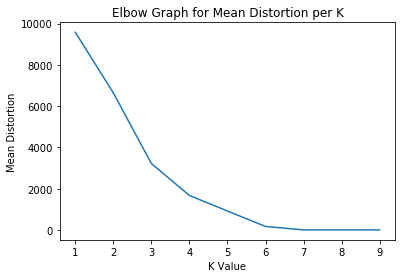

In [761]:
#Mean distortion within the range that we defined
#we will choose the value at the largest elbow
find_k(np.matrix(wowsmall), range(1,10),1)

As shown in the graph above, when K increases, the average distortion, which is
the average distance from each data point to its centroid starts to drop rapidly,
then changed to slowly at three elbow points corresponding to 3, 4 and 6, which could be 
the optimal values for K.
After tested each value based on the adjustment of the major TSNE parameters related to the visual output,
we assigned the elbow value 3 to K.

In [762]:
#Set the number of clusters that the elbow indicated above
kmeans_model = KMeans(n_clusters=4, random_state=42)
kmeans_model.fit(wowsmall_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [763]:
#Generate lable for each datapoint
#and set that to the original dataframe
wowsmall['labels']=kmeans_model.labels_

In [764]:
wowsmall.head()

,Character,Guild,Blood Elf,Orc,Tauren,Troll,Undead,Druid,Hunter,Mage,...,Wailing Caverns,Warsong Gulch,Western Plaguelands,Westfall,Wetlands,Winterspring,Zangarmarsh,Zul'Farrak,Zul'Gurub,labels
Observers,,,,,,,,,,,,,,,,,,,,,
972793,65918,316,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
973414,65918,316,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
950596,65918,316,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
951117,65918,316,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
974003,65918,316,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [765]:
wowsmall[wowsmall['labels'] == 1].head()

,Character,Guild,Blood Elf,Orc,Tauren,Troll,Undead,Druid,Hunter,Mage,...,Wailing Caverns,Warsong Gulch,Western Plaguelands,Westfall,Wetlands,Winterspring,Zangarmarsh,Zul'Farrak,Zul'Gurub,labels
Observers,,,,,,,,,,,,,,,,,,,,,
947628,43082,315,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
916456,46849,315,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
974342,43082,315,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
915171,46849,315,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1040661,46849,315,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


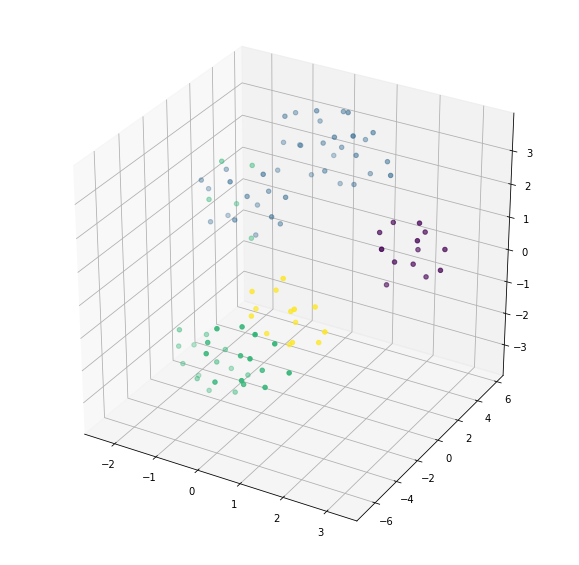

In [766]:
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

#Let's build our 3D plot
model = TSNE(n_components=3, learning_rate=12, random_state=13)
wowsmall_tsne = model.fit_transform(wowsmall) 
plt.figure(figsize=(10,10))
ax = plt.subplot(111, projection='3d')
ax.scatter(wowsmall_tsne[:, 1], wowsmall_tsne[:, 0],wowsmall_tsne[:,2], c=kmeans_model.labels_)

Here are two important parameters that are strongly affecting the layout of our 3D plot:

    n_components: Dimension of the embedded space
    learning_rate: if this value is set too high, it will make our data look like sticked cheese balls, 
    if it is too low it might cause uneven equidistant. If some of the data points are too close to each other and 
    some are too far, lower it.

# Graph Centrality

In this section, we are using panda networkx to help construct our dataframe.
First we have to draw our network graph to analyze the centrality of the specific nodes.
Here we are using Gephi as the external program to help build the graph.

In [768]:
import networkx as nx
%matplotlib inline
from matplotlib import pyplot as plt

Since we need the categorical values to create nodes and edges, we are going to use the original dataframe wow.csv.

In [769]:
#Import the original data and make a bit of houseclean
wowgephi = pd.read_csv("wow.csv")
wowgephi.index = wowgephi.index + 1
wowgephi = wowgephi.drop(['Timestamp'], axis=1)
wowgephi = wowgephi.replace([-1], [0])
wowgephi = wowgephi.sort_values(by='Guild', ascending=0)
wowgephi.head()

,Character,Level,Race,Class,Zone,Guild
935449,65918,69,Undead,Warlock,Auchindoun: Shadow Labyrinth,316
905209,65918,68,Undead,Warlock,Nagrand,316
905008,65918,68,Undead,Warlock,Nagrand,316
908298,65918,69,Undead,Warlock,Sethekk Halls,316
904203,65918,68,Undead,Warlock,Nagrand,316


In [771]:
#Output the new file for Gephi
wowgephi.to_csv('wowGephi.csv')

Let's go to Gephi now

In [772]:
M=nx.read_gml("wowGephi.gml")

In [773]:
# create weighted graph from M
G = nx.Graph()
for u,v,data in M.edges_iter(data=True):
    if G.has_edge(u,v):
        G[u][v]['weight'] += 1
    else:
        G.add_edge(u, v, weight=1)

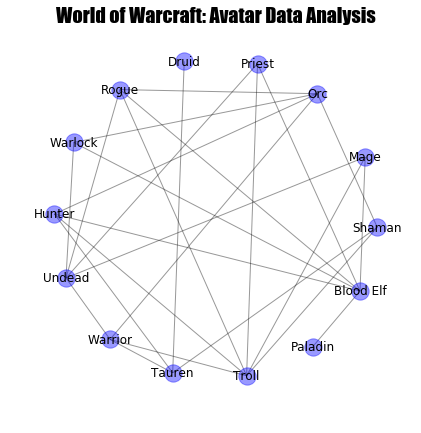

In [774]:
#Draw graph of the political blog network
plt.figure(figsize=(7,7))
pos=nx.spring_layout(G, iterations=500, scale=5, k=0.9)
nx.draw_networkx_labels(G,pos,fontsize=10)
font = {'fontname'   : 'Impact',
        'color'      : 'k',
        'fontweight' : 'bold',
        'fontsize'   : 20}
plt.title("World of Warcraft: Avatar Data Analysis", font)

nx.draw_networkx_nodes(G,pos,node_color='b',alpha=0.4)
nx.draw_networkx_edges(G,pos,alpha=0.4,node_size=10,width=1,edge_color='k')
plt.axis('off')
plt.show()

In [775]:
#Display the importance of the nodes
centrality = nx.eigenvector_centrality_numpy(G)
#Sort the centrality in descending order
bloglist = []
for node in centrality:
    bloglist.append((node,centrality[node]))
sorted_bloglist = bloglist.sort(key=lambda x: x[1])
sorted(bloglist, key=lambda x: x[1], reverse=True)

[(u'Troll', 0.3813415052773541),
 (u'Blood Elf', 0.33565021463925554),
 (u'Rogue', 0.3208976095299289),
 (u'Orc', 0.3197294387282266),
 (u'Undead', 0.3156232896280628),
 (u'Hunter', 0.2935044339940314),
 (u'Warrior', 0.28875224798806653),
 (u'Priest', 0.24502905938705183),
 (u'Mage', 0.24502905938705155),
 (u'Warlock', 0.2304091414371062),
 (u'Shaman', 0.21385804534393427),
 (u'Tauren', 0.2001814547362373),
 (u'Paladin', 0.07964638865009731),
 (u'Druid', 0.047501027108235436)]